In [1]:
# import the packages
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

<p>We are using F1 Score as model performance metric because its more appropriate in an imbalanced class problem</p>

<h3>Get the data</h3>

In [2]:
train = pd.read_csv('dataset/train.csv')
train.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_415,area_code_area_code_510
0,97,1,0,0,236.9,107,105,13.40,241.0,120,2,1.97,0,1,0,1
1,28,0,0,0,168.2,87,92,13.74,192.4,112,3,2.73,3,0,1,0
2,120,0,0,0,180.0,80,82,19.06,265.4,91,7,1.27,3,0,1,0
3,80,0,1,33,189.4,109,68,12.64,208.9,119,4,3.02,1,1,1,0
4,100,0,0,0,239.1,96,110,15.31,259.2,112,2,3.78,0,0,0,0


In [3]:
test = pd.read_csv('dataset/test.csv')
test.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_415,area_code_area_code_510
0,65,0,0,0,111.0,51,84,18.68,202.0,89,14,1.19,1,0,1,0
1,64,0,0,0,206.2,76,76,19.75,251.6,96,2,3.67,1,0,1,0
2,125,0,0,0,126.7,108,90,17.51,247.8,114,7,3.59,1,0,0,0
3,117,0,1,13,207.6,65,77,12.98,232.8,95,3,2.62,1,0,0,0
4,149,0,0,0,175.4,80,127,16.78,188.2,102,2,2.62,2,0,0,0


<p>We will use the test set only for final report on model performance</p>

In [4]:
# split the train data into train-dev set
from sklearn.model_selection import train_test_split

X = train.drop(['churn'], axis=1)
y = train['churn']

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)

<h3>XGBoost (vanilla)</h3>

In [6]:
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

xgb_basic = xgb.XGBClassifier()
xgb_basic.fit(X_train, y_train)

y_pred = np.array(xgb_basic.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))

[22:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score: 0.828


In [7]:
# hyperparameters tuning
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV

clf = xgb.XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['learning_rate'] = [0.1, 0.01, 0.05]
space['gamma'] = [0, 0.5, 1.0]
space['max_depth'] = [3, 4, 5]
space['reg_lambda'] = [0, 1, 10]
space['scale_pos_weight'] = [1, 3, 5]

clf_random = RandomizedSearchCV(clf, space, scoring='f1', n_iter=100, cv=cv, verbose=2, n_jobs=-1)
clf_random.fit(X_train, y_train)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
[22:41:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weigh...
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=Non

In [8]:
print('Best hyperparameters: {}'.format(clf_random.best_params_))

Best hyperparameters: {'scale_pos_weight': 3, 'reg_lambda': 0, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5}


<p>From these results, we should be able to narrow the range of values for each hyperparameter</p>

In [9]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['learning_rate'] = [0.1]
space['gamma'] = [0.3, 0.5, 0.7]
space['max_depth'] = [5, 8, 10]
space['reg_lambda'] = [0]
space['scale_pos_weight'] = [2, 3, 4]

clf_grid = GridSearchCV(clf, space, scoring='f1', cv=cv, n_jobs=-1)
clf_grid.fit(X_train, y_train)

[22:50:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsam

In [10]:
y_pred = np.array(clf_grid.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(clf_grid.best_params_))

F1 score: 0.836
Best hyperparameters: {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 0, 'scale_pos_weight': 4}


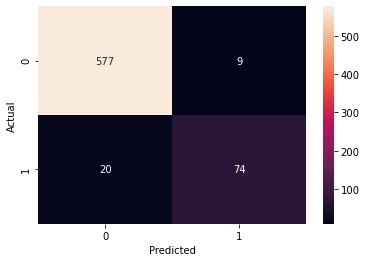

In [11]:
import seaborn as sns

conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<h3>XGBoost with SMOTE over-sampling</h3>

In [12]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

clf = xgb.XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['learning_rate'] = [0.1]
space['gamma'] = [0.3, 0.5, 0.7]
space['max_depth'] = [5, 8, 10]
space['reg_lambda'] = [0]
space['scale_pos_weight'] = [2, 3, 4]

clf_smote = GridSearchCV(clf, space, scoring='f1', cv=cv, n_jobs=-1)
clf_smote.fit(X_train_res, y_train_res)

y_pred = np.array(clf_smote.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(clf_smote.best_params_))

[22:58:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score: 0.705
Best hyperparameters: {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 0, 'scale_pos_weight': 2}


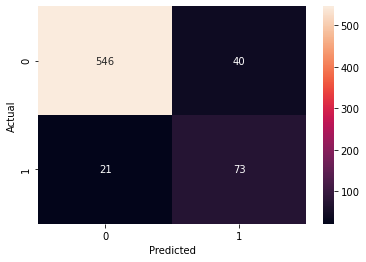

In [13]:
conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<h3>XGBoost: combination of SMOTE over-sampling with random undersampling</h3>

In [14]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

clf = xgb.XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['learning_rate'] = [0.1]
space['gamma'] = [0.3, 0.5, 0.7]
space['max_depth'] = [5, 8, 10]
space['reg_lambda'] = [0]
space['scale_pos_weight'] = [2, 3, 4]

clf_comb = GridSearchCV(clf, space, scoring='f1', cv=cv, n_jobs=-1)
clf_comb.fit(X_train_res, y_train_res)

y_pred = np.array(clf_comb.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(clf_comb.best_params_))

[23:05:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score: 0.774
Best hyperparameters: {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 0, 'scale_pos_weight': 2}


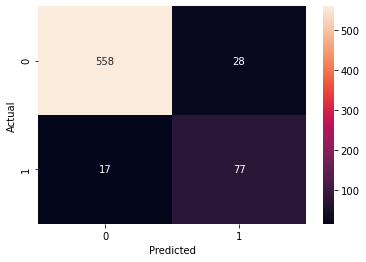

In [15]:
conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<p>It seems like tuned XGBoost method generates a higher F1 Score than any other methods</p>

<h3>Put all the pieces together</h3>

In [16]:
X_test = test.drop(['churn'], axis=1)
y_test = test['churn']

clf_grid.fit(X, y)

y_pred = np.array(clf_grid.predict(X_test))

print('F1 score: {:.3f}'.format(f1_score(y_test, y_pred)))
print('Best hyperparameters: {}'.format(clf_grid.best_params_))

[23:09:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score: 0.866
Best hyperparameters: {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 0, 'scale_pos_weight': 4}


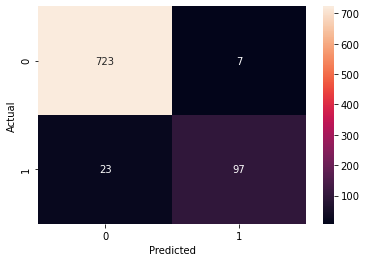

In [17]:
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

In [18]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.9647058823529412
